In [ ]:
!pip install pinecone langchain_openai langchain_pinecone langchain-community hdbscan umap-learn datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB

In [14]:
import pandas as pd

# Read the data from the CSV file all_except_tmlr.csv into a DataFrame df

df = pd.read_csv('papers.csv')

In [15]:
df.dropna(subset = ['Abstract'], inplace = True)

In [16]:
#report the frequency of each value in Conference cooumn in df
df['Conference'].value_counts()

,count
Conference,
TMLR,592
NIPS,500
CVPR,500
EMNLP,500
KDD,495


In [17]:
# remove rows whose Abstract column value is 'No abstract found'

df = df[df['Abstract'] != 'No abstract found']

In [29]:
#now pick 100 each from Conference column values KDD, NeurIPS, EMNLP, CVPR

kdd_mask = (df['Conference'] == 'KDD')
neurips_mask = (df['Conference'] == 'NIPS')
emnlp_mask = (df['Conference'] == 'EMNLP')
cvpr_mask = (df['Conference'] == 'CVPR')
tmlr_mask = (df['Conference'] == 'TMLR')

kdd_df = df.loc[kdd_mask].sample(150)
neurips_df = df.loc[neurips_mask].sample(150)
emnlp_df = df.loc[emnlp_mask].sample(150)
cvpr_df = df.loc[cvpr_mask].sample(150)
tmlr_df = df.loc[tmlr_mask].sample(150)

final_df = pd.concat([kdd_df, neurips_df, emnlp_df, cvpr_df, tmlr_df])
final_df.describe()

,Abstract,Conference
count,750,750
unique,750,5
top,"Recently, the message passing neural network (...",KDD
freq,1,150


In [19]:
df

,Abstract,Conference
0,Semi-supervised learning (SSL) offers a robust...,NIPS
1,The computational challenges of Large Language...,NIPS
2,Graph Contrastive Learning (GCL) has emerged a...,NIPS
3,Program synthesis with language models (LMs) h...,NIPS
4,"Scalarization is a general, parallizable techn...",NIPS
...,...,...
2582,"Incomputervision, thevisiontransformer(ViT)has...",TMLR
2583,The state-of-the-art dimensionality reduction ...,TMLR
2584,Continual learning is a machine learning appro...,TMLR
2585,We present an adaptive mechanism for hyperpara...,TMLR


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

def create_train_eval_split(df, test_size=0.2, random_state=42):
    """
    Split the DataFrame into training and evaluation datasets.

    Args:
        df: The original DataFrame with "Abstract" and "Label" columns.
        test_size: The proportion of the dataset to include in the evaluation split.
        random_state: Random state for reproducibility.

    Returns:
        train_df: Training DataFrame (80%).
        eval_df: Evaluation DataFrame (20%).
    """
    # Perform 80-20 split
    train_df, eval_df = train_test_split(df, test_size=test_size, random_state=random_state)

    print(f"Training Data Size: {len(train_df)}")
    print(f"Evaluation Data Size: {len(eval_df)}")
    return train_df, eval_df


train_df, eval_df = create_train_eval_split(df)

Training Data Size: 2059
Evaluation Data Size: 515


In [36]:
# Tokenizer for BART
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [37]:
import pandas as pd
from typing import Any
from datasets import Dataset
from transformers import BartTokenizer
from typing import List, Dict, Optional, Tuple, Any
from tqdm.auto import tqdm
from collections import defaultdict
from typing import Dict, List
import numpy as np

def extract_texts_and_labels_from_df(df: pd.DataFrame) -> List[Tuple[str, str]]:
    """
    Extract abstracts and conference labels from a DataFrame.

    Args:
        df: Pandas DataFrame containing 'Abstract' and 'Conference' columns.

    Returns:
        List of tuples (abstract, label).
    """
    data = []

    for _, row in df.iterrows():
        abstract = row["Abstract"]  # Text of the research abstract
        label = row["Conference"]  # Conference name (label)
        if pd.notna(abstract) and pd.notna(label):  # Ensure non-null values
            data.append((abstract, label))

    return data
def process_data_for_training(data):
    """
    Converts (abstract, label) pairs into a Hugging Face Dataset.

    Args:
        data: List of tuples (abstract, label)

    Returns:
        tokenized_dataset: Hugging Face tokenized Dataset
        label_classes: List of unique classes (conference names)
    """
    abstracts, labels = zip(*data)  # Unpack abstracts and labels
    label_classes = list(set(labels))  # Get unique labels (e.g., ["CVPR", "EMNLP", "ICML"])
    label_to_id = {label: idx for idx, label in enumerate(label_classes)}  # Map conference names to IDs
    encoded_labels = [label_to_id[label] for label in labels]  # Encode labels as IDs

    # Convert to Hugging Face Dataset
    dataset = Dataset.from_dict({"text": abstracts, "label": encoded_labels})

    # Tokenize the dataset
    tokenized_dataset = dataset.map(preprocess_function, batched=True)

    return tokenized_dataset, label_classes

# Extract texts and labels
train_data = extract_texts_and_labels_from_df(train_df)
eval_data=extract_texts_and_labels_from_df(eval_df)

tokenized_train_dataset, label_classes = process_data_for_training(train_data)
tokenized_eval_dataset, _ = process_data_for_training(eval_data)  # Use same label classes

Map:   0%|          | 0/2059 [00:00<?, ? examples/s]

Map:   0%|          | 0/515 [00:00<?, ? examples/s]

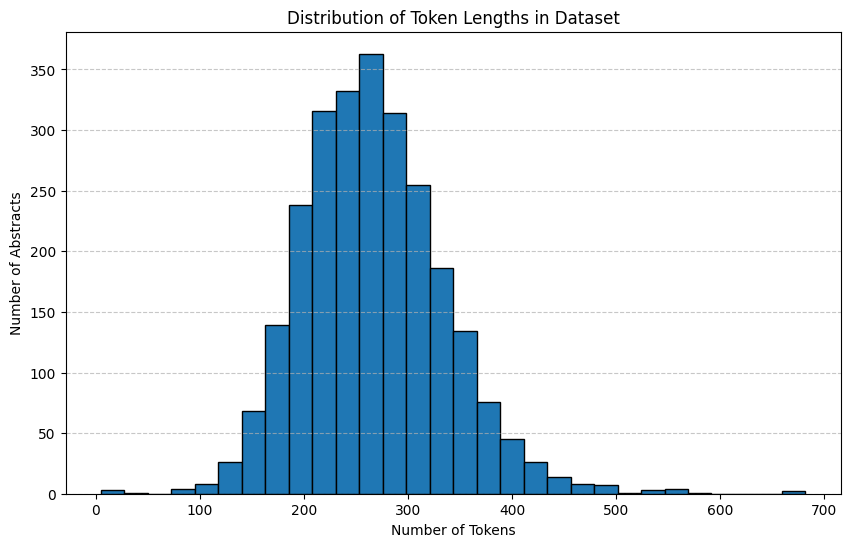

In [24]:
import matplotlib.pyplot as plt

# Get the number of tokens for each sample
token_lengths = [len(tokens["input_ids"]) for tokens in tokenized_train_dataset] #remove max_length argument for proper distribution

# Plot the histogram of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, edgecolor='black')
plt.title("Distribution of Token Lengths in Dataset")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Abstracts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [39]:
from transformers import BartForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BART for sequence classification
num_labels = len(label_classes)
model = BartForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=2,
    num_train_epochs=10,
    weight_decay=0.1,
    logging_dir='./logs',
    save_strategy="epoch"
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
)

# Train the model
trainer.train()


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.454900,0.484328
2,0.368200,0.552804
3,0.236800,0.620603
4,0.185300,0.422164
5,0.094800,0.522073
6,0.035800,0.591103
7,0.033800,0.712393
8,0.025000,0.626974
9,0.034200,0.710808
10,0.024500,0.719394


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning 

TrainOutput(global_step=10300, training_loss=0.1626203108296811, metrics={'train_runtime': 3629.3071, 'train_samples_per_second': 5.673, 'train_steps_per_second': 2.838, 'total_flos': 6314836452034560.0, 'train_loss': 0.1626203108296811, 'epoch': 10.0})

In [ ]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the correct device
model = model.to(device)

# Predict on a sample abstract
sample_text = "This paper introduces a new video recognition dataset and focuses on object detection."
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True)

# Move inputs to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    outputs = model(**inputs)
    predicted_class = outputs.logits.argmax().item()

print(f"Predicted Conference: {label_classes[predicted_class]}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Using device: cuda
Predicted Conference: NIPS


In [ ]:
import torch
from tqdm.auto import tqdm
import pandas as pd

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the correct device
model = model.to(device)

def predict_and_evaluate(df):
    """
    Perform batch inference on a DataFrame containing abstracts and labels, and compute accuracy.

    Args:
        df: Pandas DataFrame with 'Abstract' and 'Label' columns.

    Returns:
        Tuple: DataFrame with 'Predicted_Label' and accuracy score.
    """
    predictions = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Predicting labels"):
        abstract = row["Abstract"]
        inputs = tokenizer(abstract, return_tensors="pt", truncation=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to same device as model

        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_class = outputs.logits.argmax().item()
            predicted_label = label_classes[predicted_class]  # Convert to label name

        predictions.append(predicted_label)

    # Add predictions to the DataFrame
    df["Predicted_Label"] = predictions

    # Calculate accuracy
    correct_predictions = (df["Label"] == df["Predicted_Label"]).sum()
    total_samples = len(df)
    accuracy = correct_predictions / total_samples

    print(f"\nAccuracy: {accuracy:.2%}")
    return df, accuracy


# Example DataFrame (replace with your actual data)
eval_df = pd.read_csv('/content/labelled-given-test.csv')

# Perform batch inference and calculate accuracy
predictions_df, accuracy = predict_and_evaluate(eval_df)

# Display DataFrame with predictions
print(predictions_df)

Using device: cuda


Predicting labels:   0%|          | 0/10 [00:00<?, ?it/s]


Accuracy: 20.00%
                                               Title  \
0  Examining the Convergence of Denoising Diffusi...   
1  Addressing Min-Max Challenges in Nonconvex-Non...   
2  Advanced techniques for through and contextual...   
3  The Importance of Written Explanations in\nAgg...   
4  Safe Predictors for Input-Output Specification...   
5  Generalization in ReLU Networks via Restricted...   
6  Detecting Medication Usage in Parkinson’s Dise...   
7  Addressing Popularity Bias with Popularity-Con...   
8  Detailed Action Identification in Baseball Gam...   
9  Advancements in 3D Food Modeling: A Review of ...   

                                            Abstract    Label Predicted_Label  
0  Deep generative models, particularly diffusion...     TMLR            CVPR  
1  This research examines a specific category of ...     TMLR            TMLR  
2  This study examines the effectiveness of trans...    EMNLP            CVPR  
3  This study demonstrates that incorporating